In [14]:
import json
import numpy as np
import pandas as pd
import os
import time

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import PIL
from PIL import ImageDraw

%pylab inline
import matplotlib.pylab as plt
import seaborn as sns
plt.style.use('ggplot')
plt.style.use('seaborn-poster')
sns.set(style='white', context='notebook', palette='deep')

%env KERAS_BACKEND tensorflow

Populating the interactive namespace from numpy and matplotlib
env: KERAS_BACKEND=tensorflow


/Users/Denis/anaconda/envs/python3/lib/python3.5/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['plt', 'diff']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [15]:
def im2arr(drawing):
    border = 2
    # Original images are 255x255, add extra 5 to each edge.
    im = PIL.Image.new(mode='L', size=(260, 260))
    draw = PIL.ImageDraw.Draw(im)

    # Shift the strokes from edges by 5 pixels, convert them to valid format.
    for stroke in drawing:
        stroke_shifted = list(map(lambda x: tuple([i+2.5 for i in x]), 
                                  tuple(zip(stroke[0], stroke[1])))
                             )
        draw.line(stroke_shifted, fill=255, width=4)
    
    # Find the bounding box.
    bbox = PIL.Image.eval(im, lambda x: x).getbbox()
    width = bbox[2] - bbox[0] # right minus left
    height = bbox[3] - bbox[1] # bottom minus top
    # Center after croping.
    diff = width - height
    if diff >= 0:
        bbox = (bbox[0], bbox[1]-diff/2, bbox[2], bbox[3]+diff/2)
    else:
        bbox = (bbox[0]+diff/2, bbox[1], bbox[2]-diff/2, bbox[3])
    # Add borders.
    bbox = (bbox[0]-border, bbox[1]-border, bbox[2]+border, bbox[3]+border)
    
    # Crop and resize.
    im = im.crop(bbox)
    im = im.resize((px, px), resample=3)
    
    # Clip max values to make lines less blury.
    im = np.array(im).astype(float)
    im /= im.max()/2

    return im.clip(0,1)


In [16]:
px = 96
df = pd.read_csv('data/df.csv')
train = np.load('data/strokes_raw.npy')

In [20]:
batch_counter = 0
mean_global = np.zeros((px, px))
mean_global_hist = []

for i in range(100):
    print(i, end='\r')
    batch = np.random.choice(train, 1000)
    batch = np.array([im2arr(drawing) for drawing in batch])
    
    mean_global = (mean_global * batch_counter + batch.mean(axis=0)) / (batch_counter+1)
    batch_counter += 1
    mean_global_hist.append(mean_global.mean())
   
mean_global = mean_global.mean()

0.0793788735155


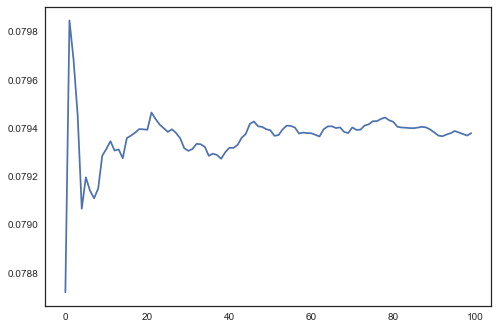

In [21]:
print(mean_global)
plt.plot(mean_global_hist);

In [ ]:
def plot_on_grid(title, recognized):
    fig = plt.figure(figsize=(15,6))
    nrows, ncols = 3, 7
    fig.suptitle(title, fontsize=16)
    img_ids = np.random.choice(df[df.recognized==recognized].index, nrows*ncols)

    for i in range(nrows * ncols):
        image_ind = img_ids[i]
        ax = fig.add_subplot(nrows, ncols, i+1)        
        ax.axis('off')
        ax.imshow(im2arr(train[image_ind]))
        ax.set_title(df.target.loc[image_ind], fontsize=14)
        
    fig.tight_layout()
    fig.subplots_adjust(top=0.85)
    plt.show()
    
plot_on_grid("Examples of recognized images", 1)
plot_on_grid("Examples of not recognized images", 0)

In [ ]:
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding

le = LabelEncoder()
ytrain = le.fit_transform(df.target.values)
ytrain = to_categorical(ytrain).astype(int)

(train, valid,
 ytrain, yvalid,
 df, dfvalid) = train_test_split(train, ytrain, df, test_size=0.1, random_state=0)

train_weights = np.array([1 if recognized==1 else 0.25 for recognized in df.recognized])
valid_weights = np.ones(valid.shape[0])

np.save('classes.npy', le.classes_)

In [3]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint

Using TensorFlow backend.


In [4]:
def batch_generator(X, y, weights, BATCH_SIZE, EPOCH_PARTION):
    """
    Batch generator for nnet training
    input:
        X - train dataset,  numpy array or csr matrix
        y - target, numpy array
        BATCH_SIZE - int, number of objects in batch. If X is csr matrix, it will be transformed 
        to dense array so batch size must be small enough for this array to fit in memory
        EPOCH_PARTION - float, share of objects that will be used for training in epoch
        
    Important: in this implementation each batch is constructed from random objects from train.
    """
    
    batch_number = 0
    
    batches_per_epoch = int(X.shape[0]/BATCH_SIZE*EPOCH_PARTION)
    while True:
        batch_indexes = np.random.choice(X.shape[0], BATCH_SIZE)
        X_batch = X[batch_indexes]
    
        X_batch = apply_parallel_sparse(X_batch, f)
        #X_batch = np.array([im2arr(drawing) for drawing in X_batch]).reshape(-1, px, px, 1)
        batch_number += 1
        yield X_batch, y[batch_indexes], weights[batch_indexes]
        if batch_number == batches_per_epoch-1:
            batch_number = 0
            
def batch_generator_p(X, BATCH_SIZE):
    """
    Batch generator for nnet predictions
    input:
        X - train dataset,  numpy array or csr matrix
        BATCH_SIZE - number of objects in batch. If X is csr matrix, it will be transformed 
        to dense array so batch size must be small enough for this array to fit in memory        
    """
     
    number_of_batches = X.shape[0] / np.ceil(X.shape[0]/BATCH_SIZE)
    batch_number = 0
    sample_index = np.arange(X.shape[0])
    while True:
        batch_indexes = sample_index[BATCH_SIZE*batch_number : BATCH_SIZE*(batch_number+1)]
        X_batch = X[batch_indexes]
        X_batch = np.array([im2arr(drawing) for drawing in X_batch])
        X_batch = X_batch.reshape(-1, px, px, 1)
        batch_number += 1
        yield (X_batch)
        if batch_number == number_of_batches:
            batch_number = 0

In [ ]:
NUM_CORES=2
def apply_parallel_sparse(DF, my_func, pool):
    
    # Get split indices for DF to split on batches with (total_rows/NUM_CORES) rows each
    total_rows = DF.shape[0]
    split_indices = []
    for i in range(NUM_CORES):
        split_on = (int(total_rows/NUM_CORES)*i)
        split_indices.append(split_on)
    split_indices.append(total_rows)
    
    # Replace input matrix with list of NUM_CORES matricies
    DF = [DF[split_indices[i]:split_indices[i+1]] for i in range(NUM_CORES)]
    
    # Apply my_func to each element of a DF list (sparse matricies) and construct final results list
    res = []
    pool = mp.Pool(NUM_CORES)
    for part_res in pool.map(my_func, DF):
        res+=part_res
    res = np.array(res).reshape(-1, px, px, 1)
    pool.close()
    return res

In [ ]:
model = Sequential()

model.add(Conv2D(filters = 32, kernel_size = (3, 3), activation='relu',
                 input_shape = (px, px, 1)))
model.add(BatchNormalization())
model.add(MaxPool2D())
model.add(Dropout(0.25))

model.add(Conv2D(filters = 64, kernel_size = (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D())
model.add(Dropout(0.25))

model.add(Conv2D(filters = 128, kernel_size = (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D())
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(ytrain.shape[1], activation='softmax'))

model.compile(loss='categorical_crossentropy', 
              optimizer = Adam(lr=1e-4),
              metrics=["accuracy"])
model.summary()

In [ ]:
EPOCH_PARTION = 0.01
BATCH_SIZE = 512

early_stopper = EarlyStopping(monitor='val_acc', patience=5, verbose=0, mode='auto')
checkpoint = ModelCheckpoint(filepath='nnet_v1.h5', monitor='val_acc', save_best_only=True)

model.fit_generator(
    generator=batch_generator(train, ytrain, train_weights, BATCH_SIZE, EPOCH_PARTION),
    samples_per_epoch=np.ceil(train.shape[0]/BATCH_SIZE*EPOCH_PARTION),    
    
#     validation_data=batch_generator(valid, yvalid, valid_weights, BATCH_SIZE, EPOCH_PARTION),
#     validation_steps = np.ceil(valid.shape[0]/BATCH_SIZE),
    
    verbose=1, nb_epoch=200,
    callbacks=[early_stopper, checkpoint]

    #use_multiprocessing=True,
    #workers=2
)

In [ ]:
# 86s

In [ ]:
%%timeit
# X_batch = np.array([im2arr(drawing) for drawing in train[:10000]])
# X_batch = X_batch.reshape(-1, px, px, 1)
batch = [im2arr(drawing) for drawing in train[:10000]]

In [ ]:
import multiprocessing as mp

NUM_CORES=4
def f(arr):
    return [im2arr(drawing) for drawing in arr]

def apply_parallel_sparse(DF, my_func):
    
    # Get split indices for DF to split on batches with (total_rows/NUM_CORES) rows each
    total_rows = DF.shape[0]
    split_indices = []
    for i in range(NUM_CORES):
        split_on = (int(total_rows/NUM_CORES)*i)
        split_indices.append(split_on)
    split_indices.append(total_rows)
    
    # Replace input matrix with list of NUM_CORES matricies
    DF = [DF[split_indices[i]:split_indices[i+1]] for i in range(NUM_CORES)]
    
    # Apply my_func to each element of a DF list (sparse matricies) and construct final results list
    res = []
    pool = mp.Pool(NUM_CORES)
    for part_res in pool.map(my_func, DF):
        res+=part_res
    res = np.array(res).reshape(-1, px, px, 1)
    pool.close()
    pool.join()
    return res

In [ ]:
%%timeit
a = apply_parallel_sparse(train[:10000], f)

In [ ]:
NUM_CORES=4
batch = train[:10240]
split_indices = [0, 2560, 2560*2, 2560*3, 10240]
batch = [batch[split_indices[i]:split_indices[i+1]] for i in range(NUM_CORES)]

In [ ]:
pool = mp.Pool(NUM_CORES)
res = []
for part_res in pool.map(f, batch):
    #yield part_res
    print(len(part_res))

In [ ]:
pool.close()

In [ ]:
from sklearn.metrics import confusion_matrix
y_hat = model.predict_generator(generator=batch_generator_p(valid, BATCH_SIZE), 
                                val_samples=np.ceil(valid.shape[0]/BATCH_SIZE))
y_pred = np.argmax(y_hat, axis=1)
y_true = np.argmax(yvalid, axis=1)
confusion = np.array(confusion_matrix(y_true, y_pred))
print(confusion)

In [ ]:
sns.heatmap(confusion.astype('float') / confusion.sum(axis=1),
            fmt='.0%',
            annot=True, 
            xticklabels=list(le.classes_),
            yticklabels=list(le.classes_),
           )
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [ ]:
plt.hist(y_hat[range(y_hat.shape[0]), np.argmax(yvalid, axis=1)], bins=np.arange(0,1,0.01));

In [11]:
import keras

model = Sequential()

model.add(Conv2D(filters = 32, kernel_size = (3, 3), activation='relu',
                 input_shape = (px, px, 1)))
model.add(BatchNormalization())
model.add(MaxPool2D())
model.add(Dropout(0.1))

model.add(Conv2D(filters = 64, kernel_size = (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D())
model.add(Dropout(0.1))

model.add(Conv2D(filters = 128, kernel_size = (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D())
model.add(Dropout(0.1))

model.add(Conv2D(filters = 64, kernel_size = (1, 1), activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.1))

model.add(Conv2D(filters = 128, kernel_size = (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.1))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.1))

model.add(Dense(330, activation='softmax'))

model.compile(loss='categorical_crossentropy', 
              optimizer = Adam(lr=5e-5),
              metrics=["accuracy"])

#model =  keras.models.load_model('nnet_v1.h5')
model.load_weights('nnet_v1.h5')
#model =  keras.models.load_model('nnet_v1_recognized.h5')

model._make_predict_function()

In [96]:
a = np.array([2,5,4,2,1])
a.argsort()[-2]

In [ ]:
i = 4
print(le.classes_[np.argmax(yvalid[mask][i])])
plt.imshow(valid[mask][i].reshape(px, px))

In [34]:
from PIL import Image, ImageOps
import PIL
import keras
all_classes = np.load('classes.npy')
# model =  keras.models.load_model('nnet_96_v1.h5')
# model._make_predict_function()

px=96
border=2

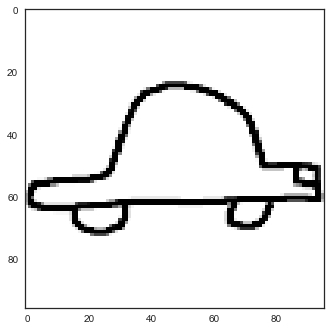

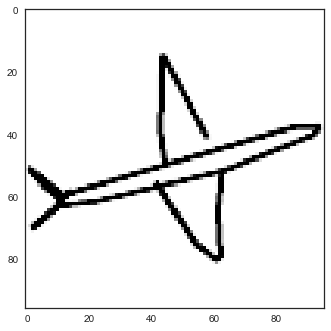

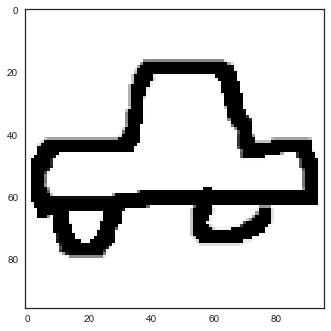

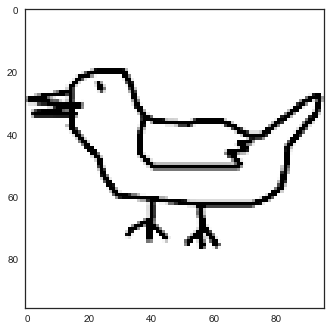

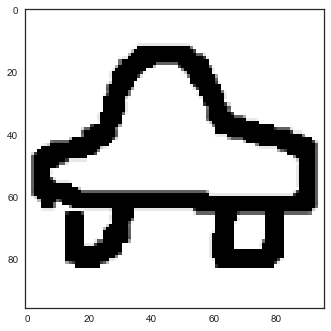

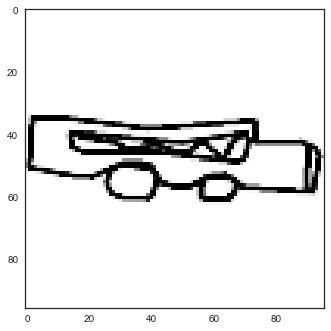

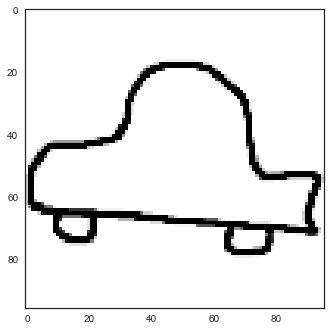

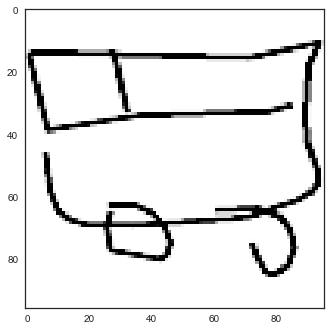

In [92]:

files_to_read = [f for f in os.listdir('../tmp/') 
        if f.endswith('.jpg')]
for f in files_to_read:
    img = Image.open('../tmp/'+f)

    # Invert colors.
    img = img.convert('L')
    img = ImageOps.invert(img)

    # Find the bounding box.
    border = 2
    bbox = Image.eval(img, lambda x: x).getbbox()
    width = bbox[2] - bbox[0] # right minus left
    height = bbox[3] - bbox[1] # bottom minus top
    # Center after croping.
    diff = width - height
    if diff >= 0:
        bbox = (bbox[0], bbox[1]-diff/2, bbox[2], bbox[3]+diff/2)
    else:
        print('sdfs')
        bbox = (bbox[0]+diff/2, bbox[1], bbox[2]-diff/2, bbox[3])
    # Add borders.
    bbox = (bbox[0]-border, bbox[1]-border, bbox[2]+border, bbox[3]+border)

    # Crop and resize.
    
#     img = img.filter(PIL.ImageFilter.GaussianBlur(3))
    
    img = img.crop(bbox)
    img = img.resize((px, px), resample=3)
    
    im = np.array(img).astype(float)

    # Clip max values to make lines less blury.
#     im[im < im.max()/1.5] = 0
    im /= im.max()/2
    im = im.clip(0, 1)
    # preds = model.predict(img.reshape(1, px, px, 1))
    # print(le.classes_[preds.argmax()], preds.max())
    #print(preds)
    #print()

    plt.imshow(im);
    plt.show()
    
    plt.imshow(im2arr(np.random.choice(train)))
    plt.show()



In [78]:
im

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

In [70]:
[im < im.max()/1.1]

[array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ..., 
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]], dtype=bool)]

In [ ]:
train[0].max()

In [ ]:
plt.figure(figsize(2,2))
plt.imshow(img2.reshape(1, px, px, 1).reshape(px, px))
plt.axis('off');

In [ ]:
model.predict(img2.reshape(1, px, px, 1))

In [ ]:
le.classes_

In [31]:
a = 'img_4.jpg'
a[4:-4]

'4'

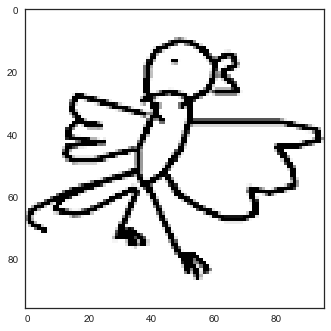